In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds

import numpy as np
import os
import PIL
import PIL.Image
import glob

import cv2

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2022-10-02 09:50:37.881213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 09:50:37.903154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 09:50:37.903287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [10]:
ds, info = tfds.load('imagenette/full-size-v2', with_info=True, as_supervised=True)
ds_train, ds_val = ds["train"], ds["validation"]

del ds

In [17]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [3]:
train_dataset = image_dataset_from_directory(
'../../imagenette/train',
image_size=(213, 160),
batch_size=1)

val_dataset = image_dataset_from_directory(
'../../imagenette/val',
image_size=(213,160),
batch_size=1)

: 

: 

In [67]:
x, y = zip(*train_dataset)
x_train = np.concatenate(x)
y_train = np.concatenate(y)

x, y = zip(*val_dataset)
x_val = np.concatenate(x)
y_val = np.concatenate(y)

In [68]:
print(x_train[0])

[[[165.40938    165.40938    163.40938   ]
  [166.22812    166.22812    164.22812   ]
  [168.04688    168.04688    166.04688   ]
  ...
  [145.         158.         166.        ]
  [146.54376    159.54376    167.54376   ]
  [147.         160.         168.        ]]

 [[164.78262    164.78262    162.78262   ]
  [165.60136    165.60136    163.60136   ]
  [167.42012    167.42012    165.42012   ]
  ...
  [145.62675    158.62675    166.62675   ]
  [146.68674    159.68674    167.68674   ]
  [147.         160.         168.        ]]

 [[163.87672    163.87672    161.87672   ]
  [164.47224    164.47224    162.47224   ]
  [166.27328    166.27328    164.27328   ]
  ...
  [146.37793    159.37793    167.37793   ]
  [146.56638    159.56638    167.56638   ]
  [146.62207    159.62207    167.62207   ]]

 ...

 [[ 37.750835    52.994976    18.128765  ]
  [ 30.858091    45.48016     12.480161  ]
  [ 33.197266    46.197266    16.291016  ]
  ...
  [ 11.048538    22.095413     4.954788  ]
  [  3.9366143   1

In [98]:
x_train = np.uint8(x_train)
print(x_train[0])

[[[165 165 163]
  [166 166 164]
  [168 168 166]
  ...
  [145 158 166]
  [146 159 167]
  [147 160 168]]

 [[164 164 162]
  [165 165 163]
  [167 167 165]
  ...
  [145 158 166]
  [146 159 167]
  [147 160 168]]

 [[163 163 161]
  [164 164 162]
  [166 166 164]
  ...
  [146 159 167]
  [146 159 167]
  [146 159 167]]

 ...

 [[ 37  52  18]
  [ 30  45  12]
  [ 33  46  16]
  ...
  [ 11  22   4]
  [  3  12   0]
  [  3  10   0]]

 [[ 39  55  19]
  [ 31  46  13]
  [ 33  46  17]
  ...
  [ 12  23   6]
  [  8  17   2]
  [  8  16   2]]

 [[ 41  57  21]
  [ 31  46  13]
  [ 34  47  17]
  ...
  [ 13  24   6]
  [ 13  22   5]
  [ 13  22   5]]]


In [99]:
conv_base = keras.applications.vgg19.VGG19(
weights="imagenet",
input_shape=(213, 160, 3),
include_top=False)
conv_base.trainable = False

In [100]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)

In [106]:
inputs = keras.Input(shape=(213, 160, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="SparseCategoricalCrossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [102]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction_without_data_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

In [105]:
history = model.fit(
x_train, y_train,
epochs=20,
validation_data=(x_val, y_val),
callbacks=callbacks)

Epoch 1/20
296/296 [==============================] - 33s 109ms/step - loss: 20.0710 - accuracy: 0.8274 - val_loss: 10.6839 - val_accuracy: 0.9254
Epoch 2/20
296/296 [==============================] - 32s 107ms/step - loss: 13.3945 - accuracy: 0.8918 - val_loss: 9.0945 - val_accuracy: 0.9371
Epoch 3/20
296/296 [==============================] - 30s 101ms/step - loss: 12.1045 - accuracy: 0.9052 - val_loss: 10.8249 - val_accuracy: 0.9325
Epoch 4/20
296/296 [==============================] - 32s 108ms/step - loss: 10.6284 - accuracy: 0.9134 - val_loss: 8.1392 - val_accuracy: 0.9383
Epoch 5/20
296/296 [==============================] - 32s 109ms/step - loss: 9.0593 - accuracy: 0.9176 - val_loss: 8.6265 - val_accuracy: 0.9355
Epoch 6/20
296/296 [==============================] - 32s 107ms/step - loss: 7.3788 - accuracy: 0.9278 - val_loss: 9.2207 - val_accuracy: 0.9368
Epoch 7/20
296/296 [==============================] - 31s 104ms/step - loss: 7.4165 - accuracy: 0.9260 - val_loss: 10.6393 -

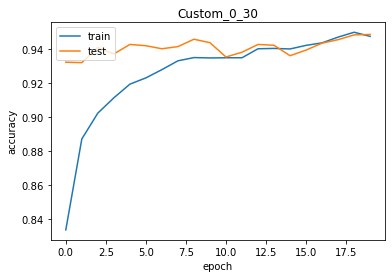

In [36]:
# Train/Test Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Custom_0_30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
from hdr_blend import*

end = len(x_train)

x_dataAug = []
y_dataAug = []
for image in range(0,end):
    x_dataAug.append(hdr(x_train[image]))
    y_dataAug.append(y_train[image])

In [39]:
y_dataAug = np.asarray(y_dataAug)
x_dataAug = np.asarray(x_dataAug, dtype=int)

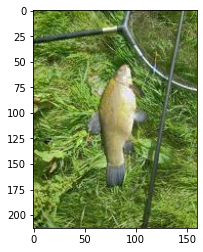

In [65]:
plt.imshow(x_dataAug[0])

In [42]:
history = model.fit(
x_dataAug, y_dataAug,
epochs=20,
validation_data=(x_val, y_val),
callbacks=callbacks)

Epoch 1/20
296/296 [==============================] - 34s 112ms/step - loss: 20.2871 - accuracy: 0.8235 - val_loss: 10.4072 - val_accuracy: 0.9266
Epoch 2/20
296/296 [==============================] - 32s 107ms/step - loss: 13.6567 - accuracy: 0.8831 - val_loss: 8.9422 - val_accuracy: 0.9399
Epoch 3/20
296/296 [==============================] - 29s 99ms/step - loss: 10.9855 - accuracy: 0.9058 - val_loss: 9.2116 - val_accuracy: 0.9338
Epoch 4/20
296/296 [==============================] - 30s 101ms/step - loss: 9.6582 - accuracy: 0.9082 - val_loss: 8.6832 - val_accuracy: 0.9404
Epoch 5/20
296/296 [==============================] - 30s 100ms/step - loss: 8.7496 - accuracy: 0.9135 - val_loss: 8.5407 - val_accuracy: 0.9363
Epoch 6/20
296/296 [==============================] - 31s 104ms/step - loss: 7.3917 - accuracy: 0.9214 - val_loss: 7.9382 - val_accuracy: 0.9396
Epoch 7/20
296/296 [==============================] - 32s 108ms/step - loss: 6.9712 - accuracy: 0.9235 - val_loss: 7.7492 - val

In [93]:
x_full = np.concatenate((x_train, x_dataAug))
y_full = np.concatenate((y_train, y_dataAug))

In [107]:
history = model.fit(
x_full, y_full,
epochs=20,
validation_data=(x_val, y_val),
callbacks=callbacks)

Epoch 1/20
592/592 [==============================] - 59s 99ms/step - loss: 17.4287 - accuracy: 0.8571 - val_loss: 10.3977 - val_accuracy: 0.9335
Epoch 2/20
592/592 [==============================] - 54s 91ms/step - loss: 10.8375 - accuracy: 0.9088 - val_loss: 8.8130 - val_accuracy: 0.9419
Epoch 3/20
592/592 [==============================] - 54s 90ms/step - loss: 8.9340 - accuracy: 0.9189 - val_loss: 8.1714 - val_accuracy: 0.9383
Epoch 4/20
592/592 [==============================] - 55s 93ms/step - loss: 6.9905 - accuracy: 0.9297 - val_loss: 8.0275 - val_accuracy: 0.9404
Epoch 5/20
592/592 [==============================] - 52s 88ms/step - loss: 5.9053 - accuracy: 0.9319 - val_loss: 8.7889 - val_accuracy: 0.9373
Epoch 6/20
592/592 [==============================] - 55s 92ms/step - loss: 5.3104 - accuracy: 0.9339 - val_loss: 6.7137 - val_accuracy: 0.9450
Epoch 7/20
592/592 [==============================] - 53s 90ms/step - loss: 4.5311 - accuracy: 0.9406 - val_loss: 7.0410 - val_accura